### 对eagle MPC的代码进行复现(主要加入模型的改变)

In [1]:
import numpy as np
import time
import copy
import crocoddyl

import eagle_mpc
from eagle_mpc.utils.simulator import AerialSimulator
from eagle_mpc.utils.plots import PlotControlsGroup, showPlots, Plot3DTrajectory, PlotStates

import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

### Step 1: 生成最优轨迹

In [2]:
# Trajectory
dt = 50  #! ms  trajectory的时间步长
useSquash = True
robotName = 'hexacopter370_flying_arm_3'

trajectoryName = 'eagle_catch_nc'  # 一共有40个时间步，每个时间步50ms，所以总共2000ms
mpcName = 'carrot'

# 首先创建一个Trajectory对象，然后读取yaml文件，设置trajectory对象的属性
trajectory = eagle_mpc.Trajectory()
trajectory.autoSetup("/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/trajectories/" + robotName +
                     '_' + trajectoryName + ".yaml")

problem = trajectory.createProblem(dt, useSquash, "IntegratedActionModelEuler")  # problem是trajectory的

if useSquash:
    solver = eagle_mpc.SolverSbFDDP(problem, trajectory.squash)
else:
    solver = crocoddyl.SolverBoxFDDP(problem)

solver.setCallbacks([crocoddyl.CallbackVerbose()])
solver.solve([], [], maxiter=200)  # 40个时间步，每个时间步5个knots 得到最优的轨迹

[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/trajectories/hexacopter370_flying_arm_3_eagle_catch_nc.yaml
[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/multicopter/hexacopter370.yaml
[EAGLE_MPC INFO]: Number of rotors: 6
[EAGLE_MPC WARN]:Initial state not found, set to the zero state
[EAGLE_MPC INFO]: Stage: take_off DOES NOT HAVE contacts
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/state_reg/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'state_reg'
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/state_limits/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'state_limits'
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/control_reg/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'control

Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.


True

/pre_grasp/costs/state_limits/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'pre_grasp': added cost 'state_limits'
[EAGLE_MPC WARN]:The following key: 'stages/pre_grasp/costs/control_reg/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'pre_grasp': added cost 'control_reg'
[EAGLE_MPC WARN]:The following key: 'stages/pre_grasp/costs/translation_ee/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC WARN]:The following key: 'stages/pre_grasp/costs/translation_ee/activation' has not been found in the parameters server. Set to quadratic activation.
[EAGLE_MPC INFO]: Stage 'pre_grasp': added cost 'translation_ee'
[EAGLE_MPC WARN]:The following key: 'stages/pre_grasp/costs/motion_ee/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'pre_grasp': added cost 'motion_ee'
[EAGLE_MPC INFO]: Stage: grasp DOES NOT HAVE contacts
[EAGLE_MPC WARN]:The fol

### 绘制planning得到的状态量和控制量
为什么状态量是19个呢
在创建模型的时候，使用了pinocchio::JointModelFreeFlyer()，这样子实现的floating base的q是7维向量，前3个是在世界坐标系的坐标向量，后4个是在世界坐标系的四元数，四元数的顺序是 (x,y,z,w)，计算的v是6维向量，分别是在local坐标系中表示的速度和角速度，加速度a同理

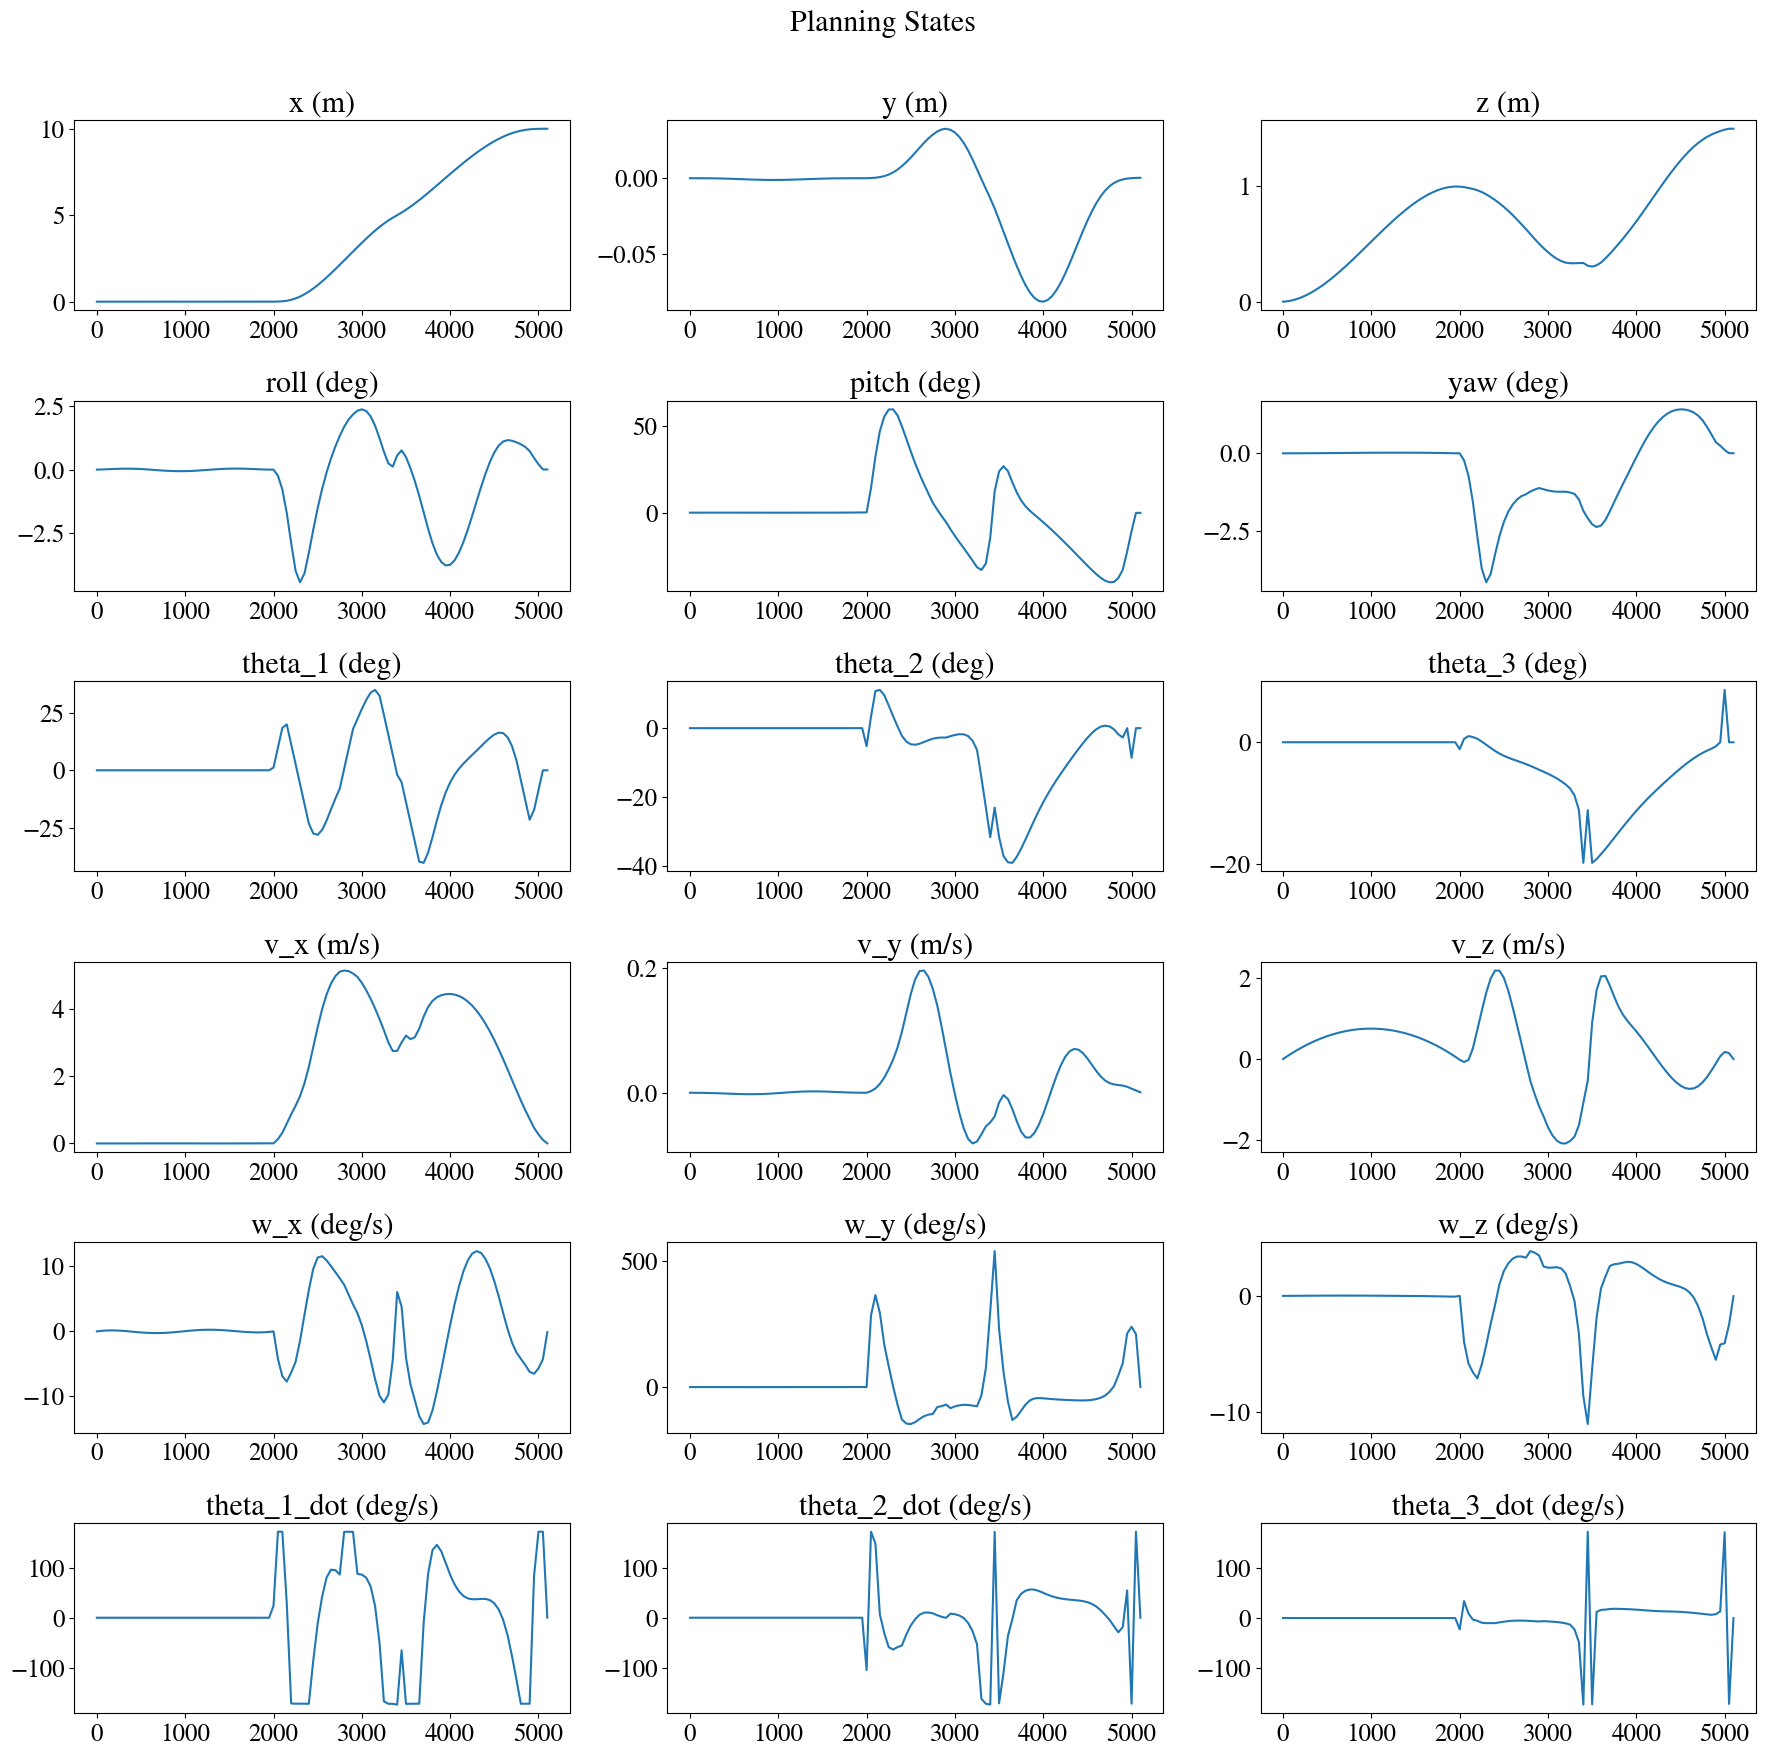

In [3]:
# 获得原始数据
xs_new = np.vstack(solver.xs).T  # 将xs从StdVec_VectorX转换为numpy array

# 对原始数据进行处理，将四元数转换为欧拉角
quaternions = xs_new[3:7, :].T # 获取四元数
rotation = R.from_quat(quaternions)  # 创建旋转对象，注意传入四元数的顺序为 [x, y, z, w]
euler_angles = rotation.as_euler('xyz', degrees=False)  # 将四元数转换为欧拉角

# 将欧拉角替换原始数据中的四元数
xs_plot = np.zeros((xs_new.shape[0] - 1, xs_new.shape[1]))  # 创建一个新的数组，用于存储替换后的数据
xs_plot[:3, :] = xs_new[:3, :]  # 将x, y, z直接复制到新数组中
xs_plot[3:6, :] = euler_angles.T  # 将欧拉角复制到新数组中
xs_plot[6:, :] = xs_new[7:, :]  # 将剩余的数据复制到新数组中

# 画图
row = 6
col = 3
fig, axes = plt.subplots(row, col, figsize=(18, 18))
rad_to_deg_list = [3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17]
title_list_1 = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
y_label_list = ['m', 'm', 'm', 'deg', 'deg', 'deg', 'deg', 'deg', 'deg', 'm/s', 'm/s', 'm/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s']

# 创建时间序列
time_plot = np.arange(0, xs_plot.shape[1] * dt, dt)  # ms

# 遍历每个子图，并进行绘制
for i in range(xs_plot.shape[0]):
    ax = axes[i // col, i % col]  # 获取当前的子图
    if i in rad_to_deg_list:
        ax.plot(time_plot, np.rad2deg(xs_plot[i, :]))
    else:
        ax.plot(time_plot, xs_plot[i, :])  # 绘制当前子图的数据
    ax.set_title(title_list_1[i]+" (" + y_label_list[i] + ")")  # 设置当前子图的标题
    # ax.set_ylabel(y_label_list[i])  # 设置当前子图的y轴标签

# 给图片添加标题
fig.suptitle('Planning States')
# 调整子图和标题之间的间距
plt.subplots_adjust(top=0.95)
# 调整子图之间的间距
plt.tight_layout(rect=[0, 0, 1, 0.95])

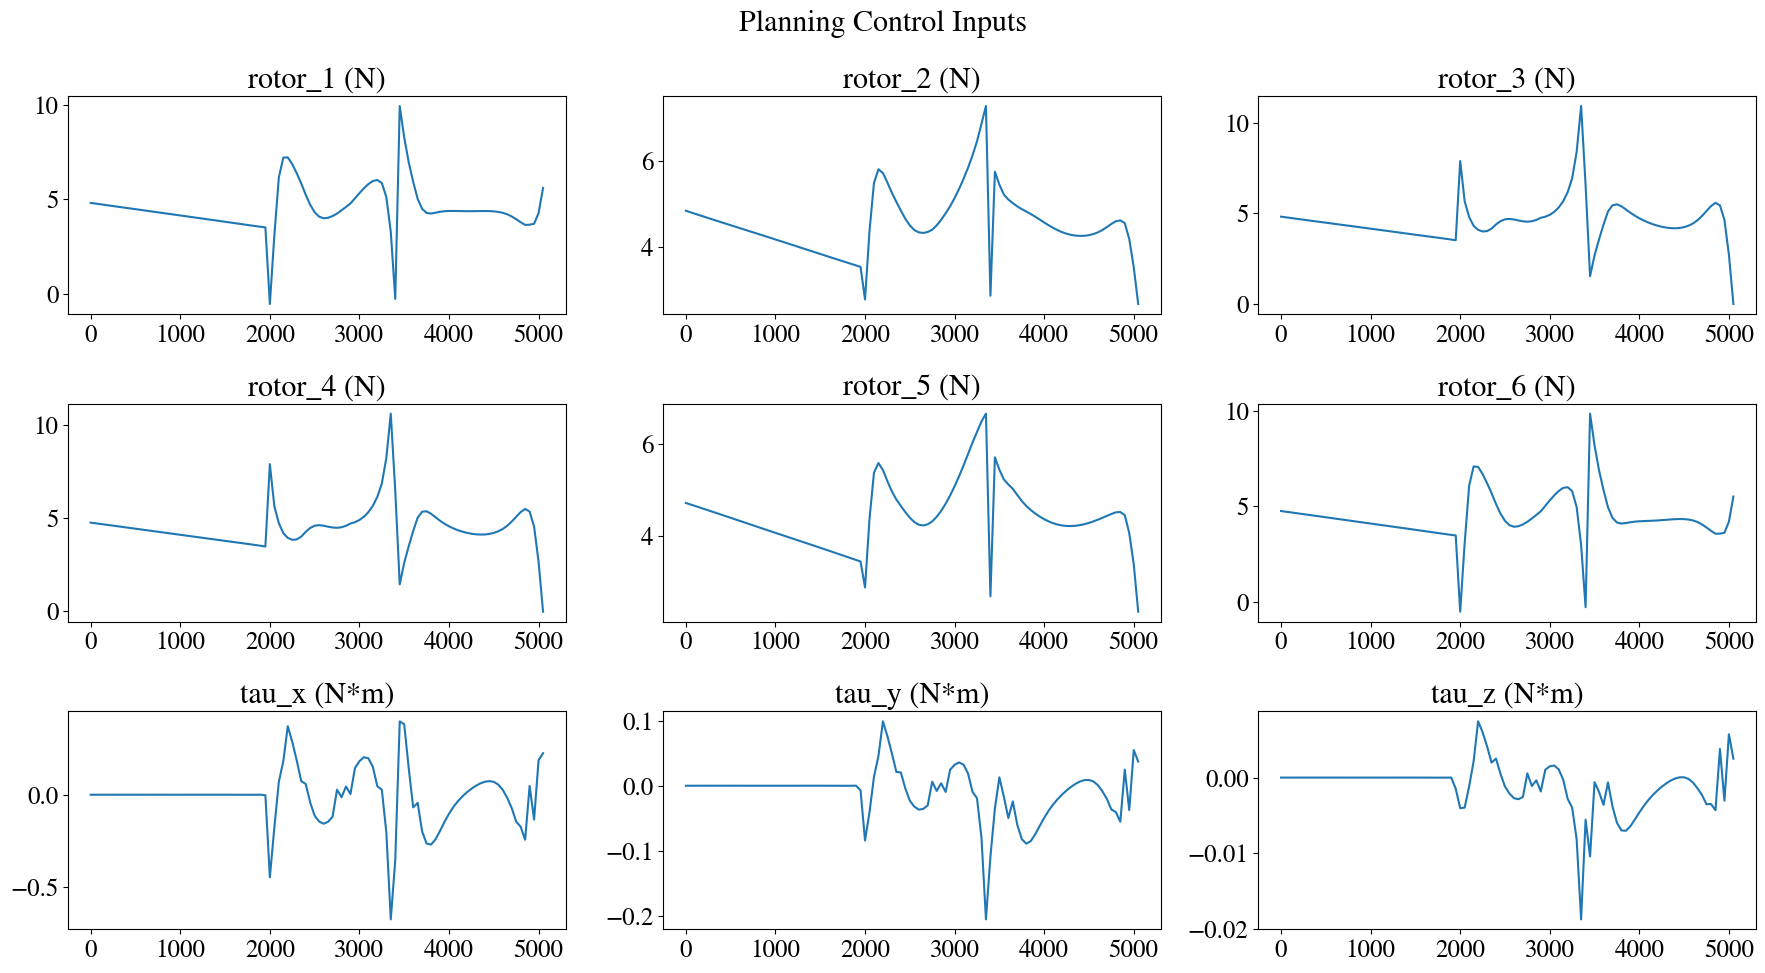

In [4]:
# 画出控制量
us_planning = np.vstack(solver.us).T
row = 3
col = 3
fig, axes = plt.subplots(row, col, figsize=(18, 10))
title_list_2 = ['rotor_1', 'rotor_2', 'rotor_3', 'rotor_4', 'rotor_5', 'rotor_6', 'tau_x', 'tau_y', 'tau_z']
y_label_list = ['N', 'N', 'N', 'N', 'N', 'N','N*m', 'N*m', 'N*m']

# 创建时间序列
time_plot = np.arange(0, us_planning.shape[1] * dt, dt)  # ms

# 遍历每个子图，并进行绘制
for i in range(us_planning.shape[0]):
    ax = axes[i // col, i % col]  # 获取当前的子图
    ax.plot(time_plot, us_planning[i, :])  # 绘制当前子图的数据
    ax.set_title(title_list_2[i]+" (" + y_label_list[i] + ")")  # 设置当前子图的标题
    # ax.set_ylabel(y_label_list[i])  # 设置当前子图的y轴标签

# 给图片添加标题
fig.suptitle('Planning Control Inputs')
# 调整子图和标题之间的间距
plt.subplots_adjust(top=0.9)
# 调整子图之间的间距
plt.tight_layout(rect=[0, 0, 1, 0.95])


### 控制器求解

In [5]:
# 创建无负载的mpc控制器
mpcController = eagle_mpc.CarrotMpc(
        trajectory, solver.xs, dt,  # trajectory duration 2000ms, dt=50ms 
        "/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/" + robotName + "_mpc.yaml")

mpcController.updateProblem(0)
mpcController.solver.solve(solver.xs[:mpcController.problem.T + 1], solver.us[:mpcController.problem.T])  
mpcController.solver.convergence_init = 1e-3

dtSimulator = 1  # 设置仿真环境的ms
simulator = AerialSimulator(mpcController.robot_model, mpcController.platform_params, dtSimulator, solver.xs[0])

t = 0
updateTime = []
solveTime = []
print(problem.T)  # 40 属于trajectory的problem 因为trajectory有2000ms，每50ms一个时间步，所以一共有40个时间步
print(int(problem.T * dt * 1.2))

control_interval = 10   # 设置控制量的间隔 相当于10ms更新一次控制量 也就是100hz

# 对无负载的mpc进行仿真
for i in range(0, int(problem.T * dt * 1.2)): 
    # 更新mpc问题
    if i % control_interval == 0:
        mpcController.problem.x0 = simulator.states[-1]  #! 从simulator中获得当前状态
        start = time.time()
        mpcController.updateProblem(int(t))  #! 可以更新当前是哪个stage
        end = time.time()
        updateTime.append(end - start)  # 记录更新时间
        
        start = time.time()
        print("Time stamp: ", t)
        mpcController.solver.solve(mpcController.solver.xs, mpcController.solver.us, mpcController.iters)   #! 解决mpc问题
        end = time.time()
        solveTime.append(end - start)  # 记录求解时间
        print("Solver time: ", end - start)
        control = np.copy(mpcController.solver.us_squash[0])
    
    # 仿真器仿真
    simulator.simulateStep(control)  # 增加i来实现模型的切换
    t += dtSimulator  # 每次增加仿真的时间步长

[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/hexacopter370_flying_arm_3_mpc.yamlRead from URDF
102
6120
Time stamp:  0
Solver time:  0.0006582736968994141

[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/multicopter/hexacopter370.yaml
[EAGLE_MPC INFO]: Number of rotors: 6
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.99889e+00  5.76000e-01  5.86500e+00  1.00000e-09  1.00000e-09   1.0000     1
   1  4.99889e+00  5.49057e-07  5.91698e-06  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.28837e+00  5.47388e-02  8.28859e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  5.28837e+00  5.83524e-09  9.41681e-08  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.99889e+00  5.79087e-02  8.29837e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  4.99889e+00  5.09

Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.
Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.
Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.


Solver time:  0.026752471923828125
Time stamp:  210
 	      ureg 	 step 	 feas
   0  4.70138e+00  3.42859e-03  1.53704e-04  1.00000e-09  1.00000e-09   1.0000     1
   1  4.70138e+00  8.07983e-09  7.54979e-08  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.68626e+00  3.22798e-03  1.45534e-04  1.00000e-09  1.00000e-09   1.0000     1
   1  4.68626e+00  7.77662e-09  7.23923e-08  1.00000e-09  1.00000e-09   1.0000     1
Solver time:  0.01735687255859375
Time stamp:  220
Solver time:  0.017482757568359375
Time stamp:  230
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.67209e+00  3.03307e-03  1.37749e-04  1.00000e-09  1.00000e-09   1.0000     1
   1  4.67209e+00  7.48207e-09  6.94369e-08  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.65925e+00  7.22339e-03  3.95619e-02  1.00000e-09  1.00000e-09   1.0000     1
   1  4.65925e+00  

In [13]:
# 创建有负载的mpc控制器
mpcController_with_load = eagle_mpc.CarrotMpc(
        trajectory, solver.xs, dt,  # trajectory duration 2000ms, dt=50ms 
        "/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/" + robotName + "_mpc.yaml")
mpcController_with_load.updateProblem(0)
mpcController_with_load.solver.solve(solver.xs[:mpcController_with_load.problem.T + 1], solver.us[:mpcController_with_load.problem.T])  
mpcController_with_load.solver.convergence_init = 1e-3

dtSimulator = 1  # 设置仿真环境的ms
simulator_with_load = AerialSimulator(mpcController.robot_model, mpcController.platform_params, dtSimulator, solver.xs[0])
# 对有负载的mpc进行仿真
t = 0
updateTime = []
solveTime = []
for i in range(0, int(problem.T * dt * 1.2)): 
    # 更新mpc问题
    if i % control_interval == 0:
        mpcController_with_load.problem.x0 = simulator_with_load.states[-1]  #! 从simulator中获得当前状态
        start = time.time()
        mpcController_with_load.updateProblem(int(t))  #! 可以更新当前是哪个stage
        end = time.time()
        updateTime.append(end - start)  # 记录更新时间
        
        start = time.time()
        print("Time stamp: ", t)
        mpcController_with_load.solver.solve(mpcController_with_load.solver.xs, mpcController_with_load.solver.us, mpcController_with_load.iters)   #! 解决mpc问题
        end = time.time()
        solveTime.append(end - start)  # 记录求解时间
        print("Solver time: ", end - start)
        control = np.copy(mpcController_with_load.solver.us_squash[0])
    
    # 仿真器仿真
    simulator_with_load.simulateCatchStep(control, i, 3500)  # 增加i来实现模型的切换
    t += dtSimulator  # 每次增加仿真的时间步长

[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/hexacopter370_flying_arm_3_mpc.yaml
Read from URDF
Time stamp:  0
Solver time:  0.00072479248046875
Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time stamp:  10
Solver time:  0.0006427764892578125
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time stamp:  20
Solver time:  0.0006191730499267578
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time stamp:  30
Solver time:  0.0006186962127685547
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time stamp:  40
Solver time:  0.0006515979766845703
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time stamp:  50
Solver time:  0.0006167888641357422
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time stamp:  60
Solver t

Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.
Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.
Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.


Solver time:  0.027640104293823242
Time: 520
Time: 521
Time: 522
Time: 523
Time: 524
Time: 525
Time: 526
Time: 527
Time: 528
Time: 529
Time stamp:  530
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.21557e+00  8.06892e-03  5.06305e-02  1.00000e-09  1.00000e-09   1.0000     1
   1  4.21556e+00  2.70186e-07  2.25463e-06  1.00000e-09  1.00000e-09   1.0000     1
Solver time:  0.014739036560058594
Time: 530
Time: 531
Time: 532
Time: 533
Time: 534
Time: 535
Time: 536
Time: 537
Time: 538
Time: 539
Time stamp:  540
Solver time:  0.014905452728271484
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.20457e+00  2.61553e-03  1.92668e-04  1.00000e-09  1.00000e-09   1.0000     1
   1  4.20457e+00  1.61338e-08  1.33776e-07  1.00000e-09  1.00000e-09   1.0000     1
Time: 540
Time: 541
Time: 542
Time: 543
Time: 544
Time: 545
Time: 546
Time: 547
Time: 548
Time: 549
Time stamp:  550
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas


### 输出控制指令

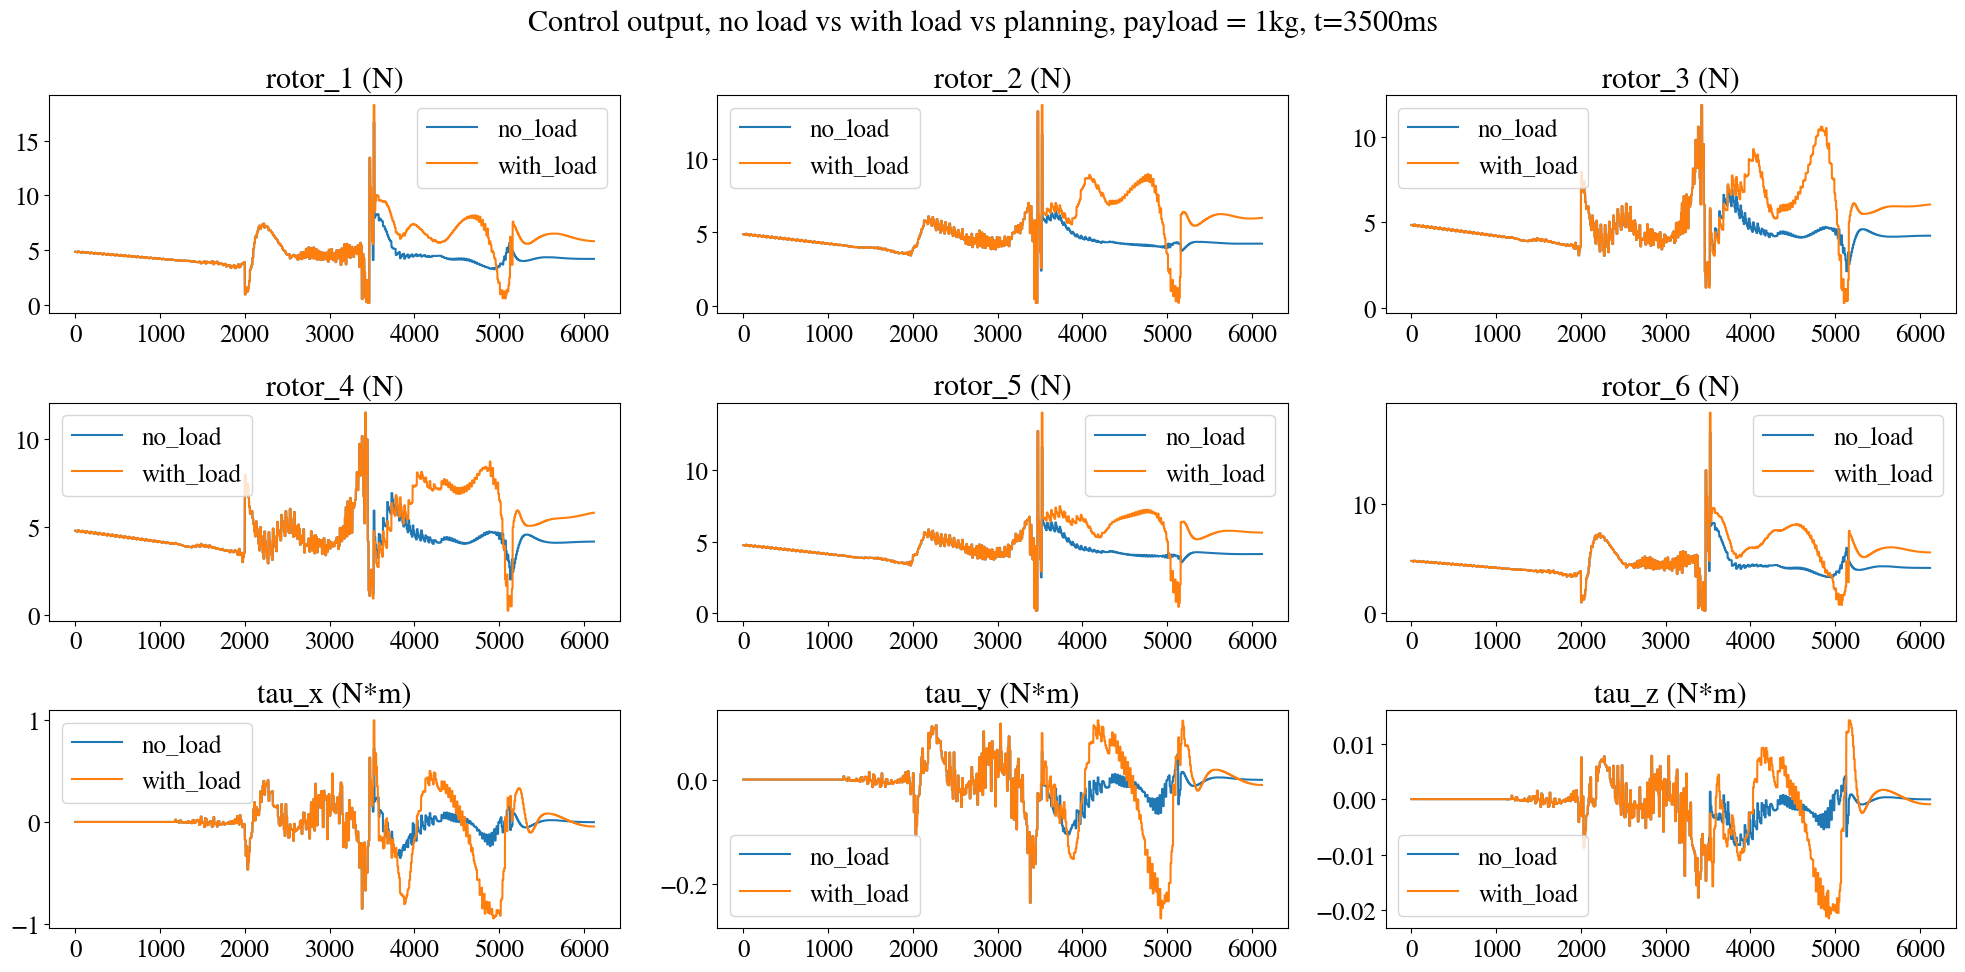

In [15]:
us_plot_mpc = np.vstack(simulator.controls).T  # 对记录的控制量进行转置
us_plot_mpc_with_load = np.vstack(simulator_with_load.controls).T  # 对记录的控制量进行转置
us_planning = np.vstack(solver.us).T  # 对记录的控制量进行转置

row = 3
col = 3
fig, axes = plt.subplots(row, col, figsize=(20, 10))

title_list_control = ['rotor_1', 'rotor_2', 'rotor_3', 'rotor_4', 'rotor_5', 'rotor_6', 'tau_x', 'tau_y', 'tau_z']
y_label_list_control = ['N', 'N', 'N', 'N', 'N', 'N','N*m', 'N*m', 'N*m']

# 创建时间序列
time_plot = np.arange(0, us_planning.shape[1] * dt, dt)  # ms

# 遍历每个子图，并进行绘制
for i in range(us_plot_mpc.shape[0]):
    ax = axes[i // row, i % col]  # 获取当前的子图
    
    ax.plot(us_plot_mpc[i, :], label='no_load')  # 绘制当前子图的数据
    ax.plot(us_plot_mpc_with_load[i, :], label='with_load')  # 绘制当前子图的数据
    # ax.plot(time_plot, us_planning[i, :], label='planning', color='b')  # 绘制当前子图的数据
    
    ax.set_title(title_list_control[i] + " (" + y_label_list_control[i] + ')')  # 设置当前子图的标题
    ax.legend()  # 显示图例

# 给图片添加标题
fig.suptitle('Control output, no load vs with load vs planning, payload = 1kg, t=3500ms')
# 调整子图和标题之间的间距
plt.subplots_adjust(top=0.95)
# 调整子图之间的间距
plt.tight_layout(rect=[0, 0, 1, 0.95])

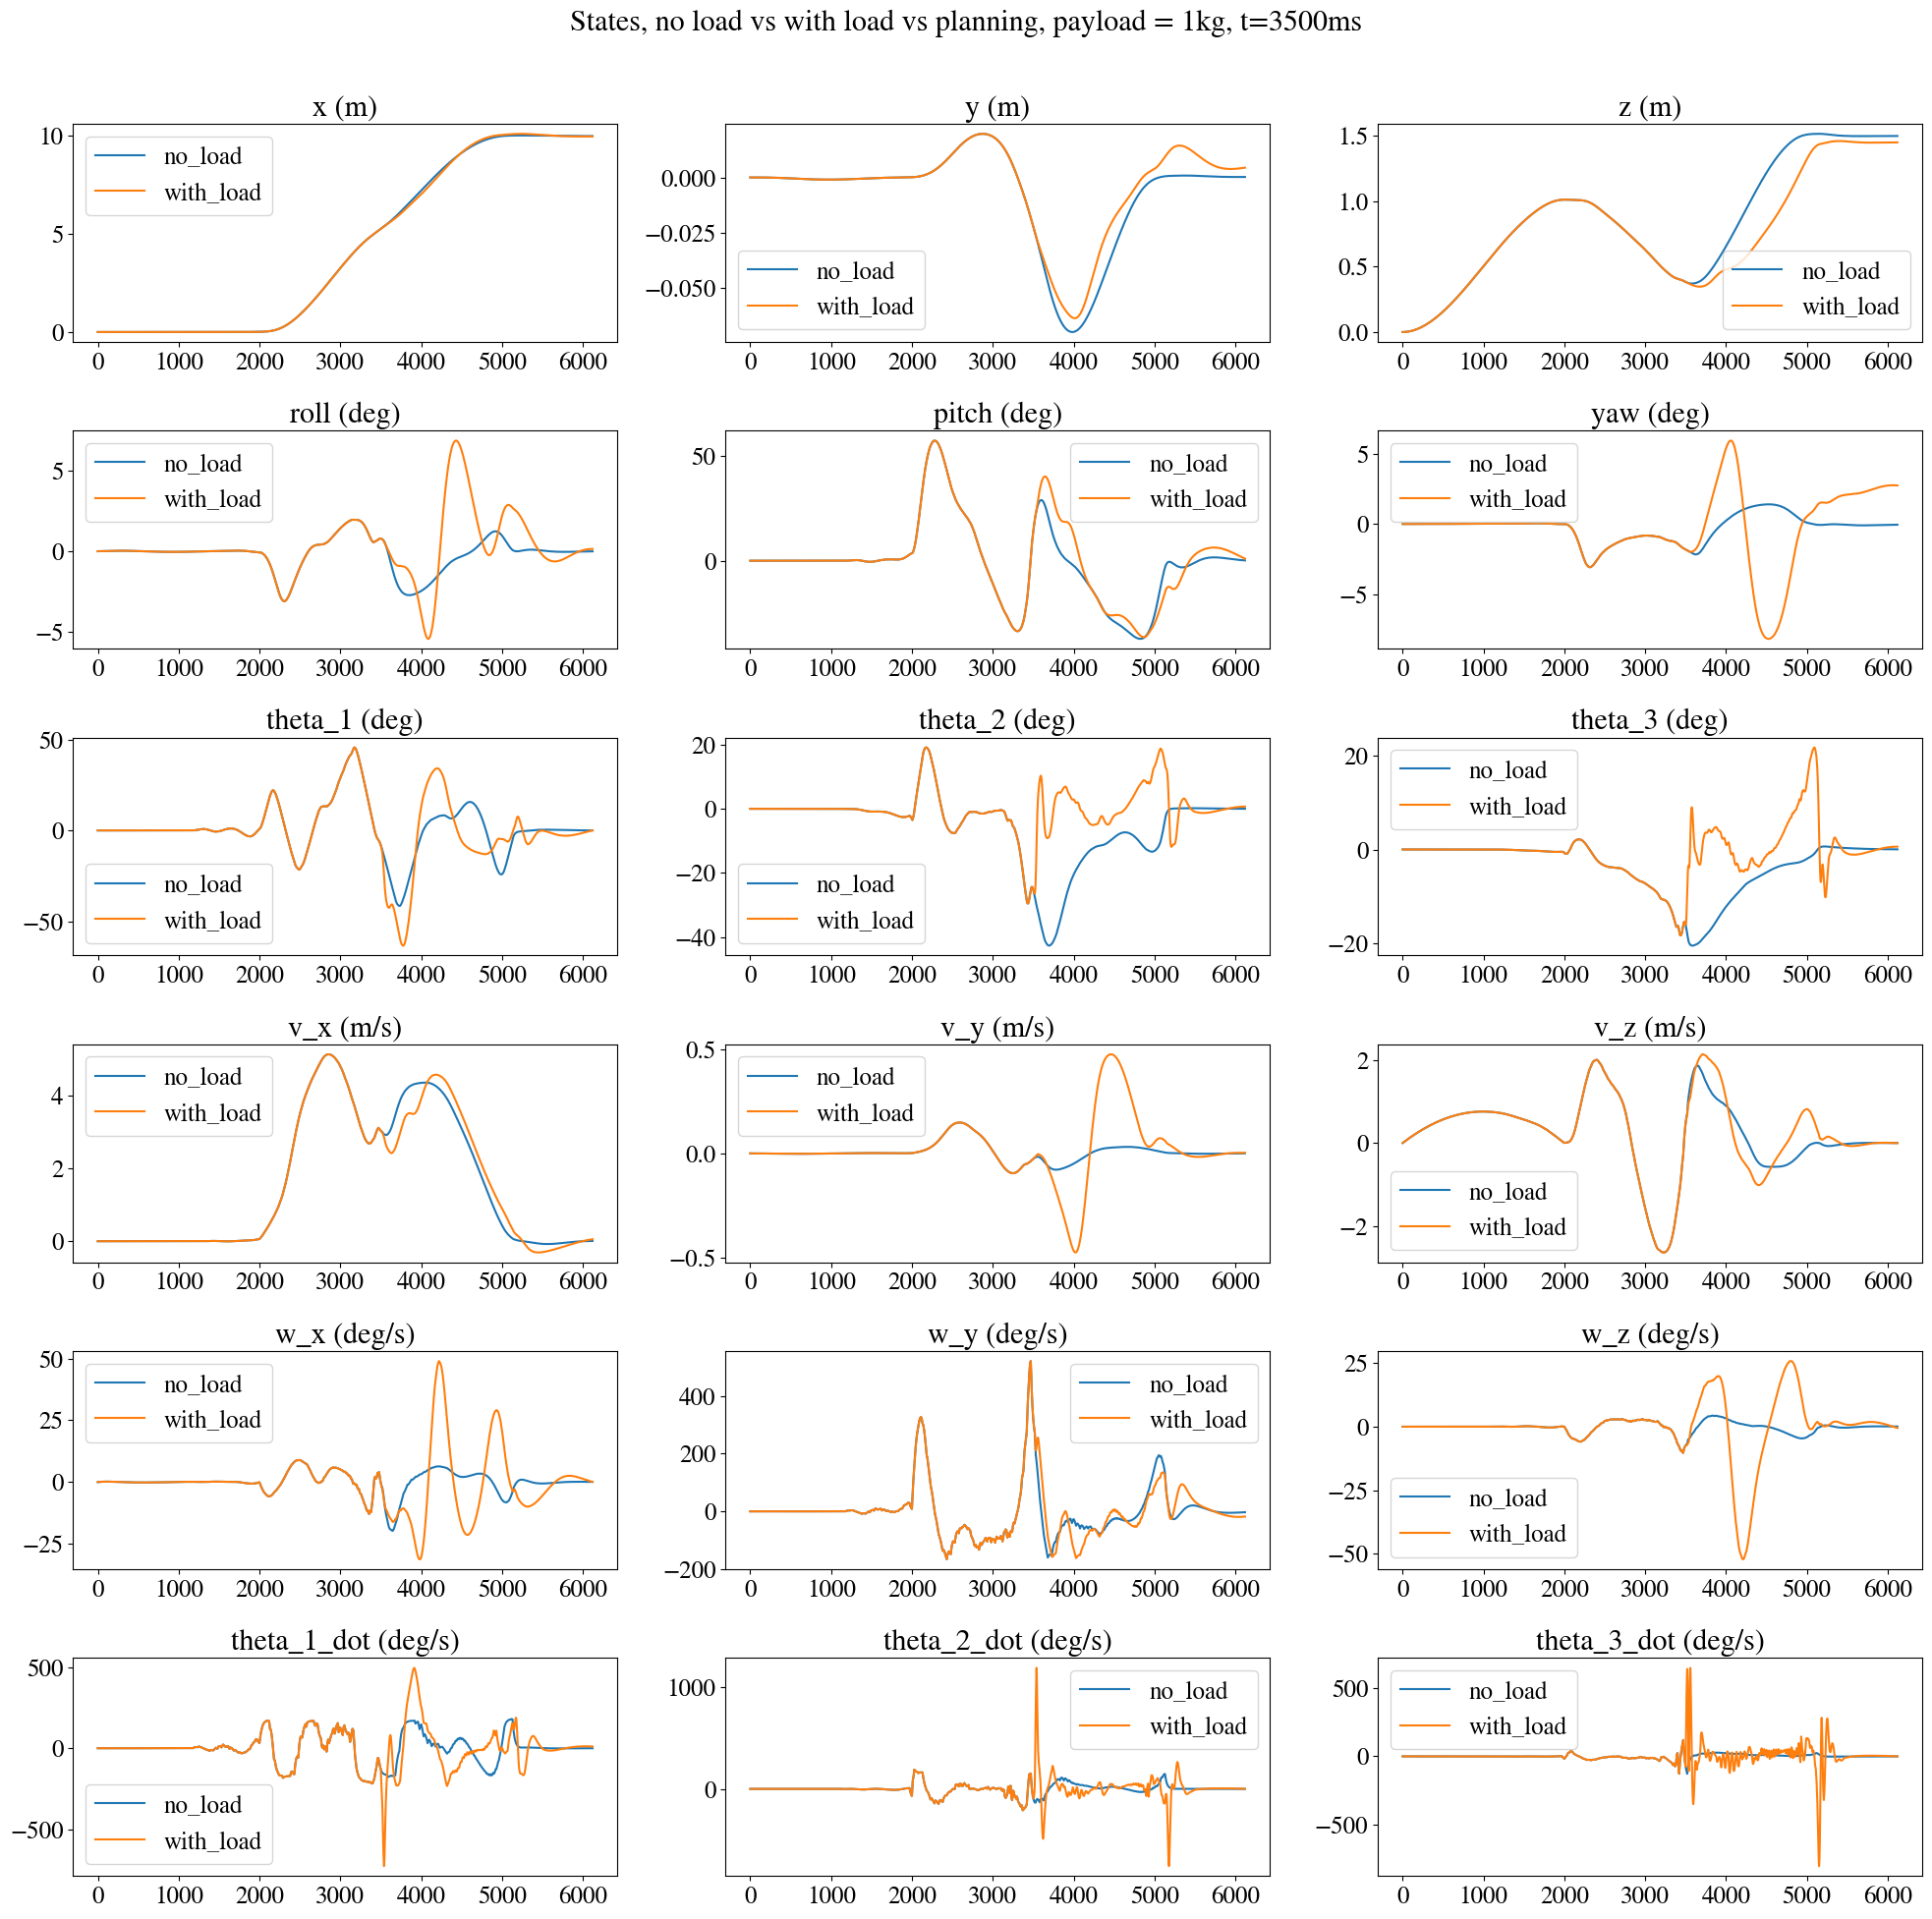

In [16]:
def getStateWithEuler(states, toDegree=True):
    '''
    description: 将四元数转换为欧拉角，并替换原始数据中的四元数
    return {*}
    '''    
    quaternions = states[3:7, :].T  # 获取四元数
    rotation = R.from_quat(quaternions)  # 创建旋转对象，注意传入四元数的顺序为 [x, y, z, w]
    euler_angles = rotation.as_euler('xyz', degrees=False)  # 将四元数转换为欧拉角

    # 将欧拉角替换原始数据中的四元数
    states_plot = np.zeros((states.shape[0] - 1, states.shape[1]))  # 创建一个新的数组，用于存储替换后的数据
    states_plot[:3, :] = states[:3, :]  # 将x, y, z直接复制到新数组中
    states_plot[3:6, :] = euler_angles.T  # 将欧拉角复制到新数组中
    states_plot[6:, :] = states[7:, :]  # 将剩余的数据复制到新数组中
    
    if toDegree:
        states_plot[3:9, :] = np.rad2deg(states_plot[3:9, :])
        states_plot[12:, :] = np.rad2deg(states_plot[12:, :])
    
    return states_plot

# 获得原始数据
xs_new = np.vstack(solver.xs).T  # 将xs从StdVec_VectorX转换为numpy array
xs_no_load = np.vstack(simulator.states).T
xs_with_load = np.vstack(simulator_with_load.states).T

xs_planning_plot = getStateWithEuler(xs_new)
xs_no_load_plot = getStateWithEuler(xs_no_load)
xs_with_load_plot = getStateWithEuler(xs_with_load)

# 画图
row = 6
col = 3
fig, axes = plt.subplots(row, col, figsize=(20, 20))
rad_to_deg_list = [3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17]
title_list_1 = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
y_label_list = ['m', 'm', 'm', 'deg', 'deg', 'deg', 'deg', 'deg', 'deg', 'm/s', 'm/s', 'm/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s', 'deg/s']

# 创建时间序列
time_plot = np.arange(0, xs_planning_plot.shape[1] * dt, dt)  # ms

# 遍历每个子图，并进行绘制
for i in range(xs_planning_plot.shape[0]):
    ax = axes[i // col, i % col]  # 获取当前的子图
    
    ax.plot(xs_no_load_plot[i, :], label='no_load')  # 绘制当前子图的数据
    ax.plot(xs_with_load_plot[i, :], label='with_load')  # 绘制当前子图的数据
    # ax.plot(time_plot, xs_planning_plot[i, :], color='b', label='planning')  # 绘制当前子图的数据
    
    ax.set_title(title_list_1[i]+" (" + y_label_list[i] + ")")  # 设置当前子图的标题
    ax.legend()  # 显示图例

# 给图片添加标题
fig.suptitle('States, no load vs with load vs planning, payload = 1kg, t=3500ms')
# 调整子图和标题之间的间距
plt.subplots_adjust(top=0.95)
# 调整子图之间的间距
plt.tight_layout(rect=[0, 0, 1, 0.95])